In [2]:
#! /usr/bin/python

# **************************************#
# -- coding: utf-8 --                   #
# **************************************#
# Author:                               #
# João Paulo Cardoso do Carmo           #
# Date: 2025-08-30                      #
# **************************************#

#*********** Imports ***********
import matplotlib.pyplot as plt
import branca.colormap as cm
import geopandas as gpd
import seaborn as sns
import pandas as pd
import os

In [5]:
def task_02():
    """
    - a) Procure uma fonte de dados confiável na internet de população e PIB dos municípios
    brasileiros e salve os dados de população e PIB dos municípios de Minas Gerais
    em um arquivo CSV com o nome dados/populacao-pib-municipios-mg.csv.
    
    - b) Utilize os dois arquivos de focos de desmatamento como base
    (dados/desmatamento_ago22.gpkg e dados/desmatamento_set_22.gpkg), 
    junte-os em um único dataset, transforme-o em um GeoJSON na projeção EPSG:31983 e
    salve-o em dados/focos-desmatamento-mg.geojson.

    - c) No notebook 02_analise.ipynb, faça uma análise exploratória dos dados,
     respondendo às seguintes perguntas:
        - c.1) Qual a área total desmatada em hectares no estado de Minas Gerais 
        em cada um dos meses de agosto e setembro de 2022?
        - c.2) Qual a área total desmatada em km² no estado de Minas Gerais em todo o
         período fornecido (ago/set de 2022) por bioma?
        - c.3) Qual a área total desmatada em km² no estado de Minas Gerais
         em cada um dos meses de agosto e setembro de 2022, por município?

    - d) No notebook 02_analise.ipynb faça uma análise de correlação entre as
    variáveis de população e PIB dos municípios de Minas Gerais e a área
    desmatada em hectares. Apresente os resultados da forma que achar mais adequada.
    """

    def a()->pd.DataFrame:
        # Path input
        path_input = os.path.join("..", "dados", "task_02", "ibge_mg.xlsx")
        # Reading file
        dataframe = pd.read_excel(path_input)
        #Filter columns
        dataframe = dataframe[["Município [-]", "PIB per capita - R$ [2021]", "População no último censo - pessoas [2022]"]]
        # Path to save
        path_output = os.path.join("..", "dados","populacao-pib-municipios-mg.csv")
        dataframe.to_csv(path_output)
        print(f"Caminho do csv: {path_output}") 

        return dataframe

    def b()->gpd.GeoDataFrame:
        """
        Observações:
        - O UTM não ficou harcode (31982), e sim usando a lib do geopandas que é mais robusta.
        - Foi salvo em UTM o arquivo pois exigia na task, porém NÃO é uma boa prática salvar
        geojson em UTM usando geopandas devido a problemas de versões.
        """
        # Base path
        base_dir = os.path.join("..", "dados")
        # Create master dataset
        master_dataset = gpd.GeoDataFrame(geometry=[], crs=4326)

        for file in os.listdir(base_dir):
            # Check ext
            if "gpkg" in file:
                # Get path file
                file_path = os.path.join(base_dir, file)
                # Read file
                gframe = gpd.read_file(file_path)
                # Add date
                if "ago" in file:
                    gframe["mes"] = "agosto"
                elif "set" in file:
                    gframe["mes"] = "setembro"

                # Join dataset
                master_dataset = pd.concat([master_dataset, gframe], ignore_index=True)
        
        # Find utm crs
        utm_crs = master_dataset.estimate_utm_crs()
        # Convert to UTM 
        master_dataset = master_dataset.to_crs(utm_crs)
        # Path to save
        file_path = os.path.join("..", "dados", "focos-desmatamento-mg.geojson")
        # Save geojson
        master_dataset.to_file(file_path)

        # Output to user
        print(f"Task 02, b) done, file path: {file_path}")
        return master_dataset

    def c(gframe:gpd.GeoDataFrame):
        # Convert to km² and remove geometry
        gframe["area_km2"] = gframe.area / 1e6
        gframe = gframe.drop(columns="geometry")

        # Filtering for August and September 2022
        gframe_august = gframe[gframe["mes"] == "agosto"]
        gframe_september = gframe[gframe["mes"] == "setembro"]

        # Total deforested area in August
        total_august = gframe_august["area_km2"].sum()
        print(f"Deforested area in August 2022: {total_august * 100} hectares")

        # Total deforested area in September
        total_september = gframe_september["area_km2"].sum()
        print(f"Deforested area in September 2022: {total_september  * 100} hectares")

        # Now, total deforested area by biome
        dataframe_biome = gframe.groupby("Bioma")["area_km2"].sum()
        print("\nTotal deforested area by biome (in km²):")
        print(dataframe_biome)

        # Now, total deforested area by municipality
        dataframe_municipality = gframe.groupby("NuFis")["area_km2"].sum()
        print("\nTotal deforested area by municipality (in km²):")
        print(dataframe_municipality)

    def d(dataframe_pib_population:pd.DataFrame, gframe_deforestation:gpd.GeoDataFrame):
        # Find deforestation by municipality
        path_full_municipality = os.path.join("..", "dados", "municipios-mg.geojson")
        # Read file
        municipality = gpd.read_file(path_full_municipality)
        # Convert to utm
        municipality = municipality.to_crs(gframe_deforestation.crs)
        # Explode file
        municipality = municipality.reset_index(drop=True).explode(ignore_index=True)

        # Create geodataframe with informations necessary
        date_by_city = gpd.GeoDataFrame(geometry=[], crs=municipality.crs)
        date_by_city.geometry = municipality.geometry
        date_by_city["municipio"] = municipality["name"]
        date_by_city["desmatamento_hectare"] = 0
        date_by_city["populacao"] = 0
        date_by_city["pib"] = 0
        
        # Drop var
        del municipality

        for i, city_area in date_by_city.iterrows():
            deforestation = gframe_deforestation[gframe_deforestation.intersects(city_area.geometry)]
            if deforestation.empty: continue
            # Add area deforestation into date_by_city
            date_by_city.at[i, "desmatamento_hectare"] = sum(deforestation.area / 1e4)
            # Find match with dataframe_pib_population
            match_city = dataframe_pib_population[dataframe_pib_population["Município [-]"] == city_area.municipio]
            if match_city.empty: continue
            date_by_city.at[i, "populacao"] = int(match_city["População no último censo - pessoas [2022]"].iloc[0])
            date_by_city.at[i, "pib"] = int(match_city["PIB per capita - R$ [2021]"].iloc[0])
        
        # Drop nan values
        date_by_city = date_by_city[(date_by_city != 0).all(axis=1)]
        # Get corr
        corr_matrix = date_by_city[["populacao", "pib", "desmatamento_hectare"]].corr(method="pearson")

        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

        # Save pdf
        path_save = os.path.join("..", "dados", "task_02", "correlation_matrix.pdf")
        plt.title("Matriz de Correlação")
        plt.savefig(path_save, format='pdf')
        plt.show()
        plt.close()

        print(f"PDF de correlação salvo em: {path_save}")

    # A fom task 2
    dataframe_pib_population = a()

    # B fom task 2
    gframe_deforestation = b()

    # C fom task 2
    c(gframe_deforestation)

    # D fom task 2
    d(dataframe_pib_population, gframe_deforestation)


Caminho do csv: ..\dados\populacao-pib-municipios-mg.csv
Task 02, b) done, file path: ..\dados\focos-desmatamento-mg.geojson
Deforested area in August 2022: 12557.693586320747 hectares
Deforested area in September 2022: 28605.44949909937 hectares

Total deforested area by biome (in km²):
Bioma
Caatinga           58.671766
Cerrado           234.941821
Mata Atlântica    118.017844
Name: area_km2, dtype: float64

Total deforested area by municipality (in km²):
NuFis
Alto Paranaíba           47.619232
Alto São Francisco       11.087289
Central Metropolitana     9.066804
Jequitinhonha            18.377158
Leste                    12.883127
Nordeste                 10.767701
Noroeste                 66.209746
Norte                    99.554537
Sul                      21.239121
Triângulo Mineiro        97.933245
Zona da Mata             16.893469
Name: area_km2, dtype: float64


C:\Users\leobelini\AppData\Local\Temp\ipykernel_8156\3702900877.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.86710506589727' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  date_by_city.at[i, "desmatamento_hectare"] = sum(deforestation.area / 1e4)


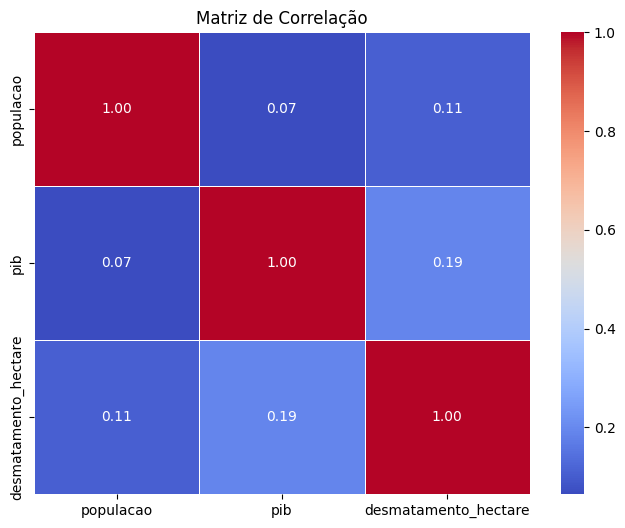

PDF de correlação salvo em: ..\dados\task_02\correlation_matrix.pdf


In [6]:
task_02()